# Neruo Kit
- https://neuropsychology.github.io/NeuroKit/functions/ecg.html

In [2]:
import os
import pandas as pd
import neurokit2 as nk
import numpy as np

ecg_path = '/tf/hsh/new_ecg/lead2/'
ecg_list = os.listdir(ecg_path)

# Load the ECG data
data = pd.read_csv(f"{ecg_path}/{ecg_list[1000]}")

In [4]:
# Extract the II lead signal and sampling rate
ecg_signal = data["II"].values
sampling_rate = 500  # Assuming 500Hz sampling rate based on the time steps in your data

# 1. Preprocess the ECG signal
ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate)

# 2. Extract ECG features
ecg_signals, ecg_info = nk.ecg_process(ecg_cleaned, sampling_rate=sampling_rate)

# Extract R-peaks (for rhythm analysis and heart rate calculation)
r_peaks = ecg_info['ECG_R_Peaks']

# Remove any NaN values from R-onsets, R-offsets, and other features
qrs_onsets = [onset for onset in ecg_info['ECG_R_Onsets'] if not np.isnan(onset)]
qrs_offsets = [offset for offset in ecg_info['ECG_R_Offsets'] if not np.isnan(offset)]

# 3. Calculate Heart Rate from R-peaks
if len(r_peaks) > 1:
    rr_intervals = np.diff(r_peaks) / sampling_rate  # Time difference between successive R peaks (in seconds)
    heart_rate = 60 / np.mean(rr_intervals)  # Convert RR interval to beats per minute (bpm)
else:
    heart_rate = np.nan  # Not enough R-peaks to calculate heart rate

# Rhythm Analysis: If RR intervals are constant, it's regular
rhythm = 'regular' if np.std(rr_intervals) < 0.12 else 'irregular'

# P-waves detection (this is built into the neurokit2 process)
p_peaks = ecg_info['ECG_P_Peaks']

# PR Interval (difference between P peak and R peak)
pr_intervals = []
for p_peak in p_peaks:
    r_after_p = r_peaks[r_peaks > p_peak][0]  # Find the first R peak after the P peak
    pr_interval = (r_after_p - p_peak) / sampling_rate
    pr_intervals.append(pr_interval)
mean_pr_interval = np.mean(pr_intervals)

# QRS Complex duration: Check if QRS onsets and offsets are detected
if len(qrs_onsets) > 0 and len(qrs_offsets) > 0:
    qrs_durations = []
    for onset, offset in zip(qrs_onsets, qrs_offsets):
        qrs_duration = (offset - onset) / sampling_rate
        qrs_durations.append(qrs_duration)
    mean_qrs_duration = np.mean(qrs_durations)
else:
    mean_qrs_duration = np.nan  # No QRS detection, handle missing data

# T-waves detection
t_peaks = ecg_info.get('ECG_T_Peaks', [])

# T-wave analysis: Look for abnormally high or inverted T waves
if len(t_peaks) > 0:
    t_wave_amplitudes = ecg_cleaned[t_peaks]
    t_wave_inverted = np.any(t_wave_amplitudes < 0)
else:
    t_wave_amplitudes = []
    t_wave_inverted = False

# QT Interval (from QRS onset to T wave offset): Check if T-peaks and QRS onsets exist
if len(qrs_onsets) > 0 and len(t_peaks) > 0:
    qt_intervals = []
    for onset, t_peak in zip(qrs_onsets, t_peaks):
        qt_interval = (t_peak - onset) / sampling_rate
        qt_intervals.append(qt_interval)
    mean_qt_interval = np.mean(qt_intervals)
else:
    mean_qt_interval = np.nan  # No T-wave or QRS detection

# ST Segment Analysis: Only calculate if QRS offsets are available
st_segment_window = int(0.08 * sampling_rate)  # 80 ms window
if len(qrs_offsets) > 0:
    st_elevations = []
    for offset in qrs_offsets:
        if offset + st_segment_window < len(ecg_cleaned):
            st_elevation = np.mean(ecg_cleaned[offset:offset + st_segment_window])
            st_elevations.append(st_elevation)
    mean_st_elevation = np.mean(st_elevations)
else:
    mean_st_elevation = np.nan  # Handle missing ST segment

# Results
print("Heart Rate (bpm):", heart_rate)
print("Rhythm:", rhythm)
print("PR Interval (mean, seconds):", mean_pr_interval)
print("QRS Duration (mean, seconds):", mean_qrs_duration)
print("QT Interval (mean, seconds):", mean_qt_interval)
print("ST Segment Elevation (mean):", mean_st_elevation)
print("T-Wave Inverted:", t_wave_inverted)

Heart Rate (bpm): 59.132720105124825
Rhythm: regular
PR Interval (mean, seconds): 0.125
QRS Duration (mean, seconds): 0.17200000000000001
QT Interval (mean, seconds): 0.39266666666666666
ST Segment Elevation (mean): -0.048675423790032785
T-Wave Inverted: False


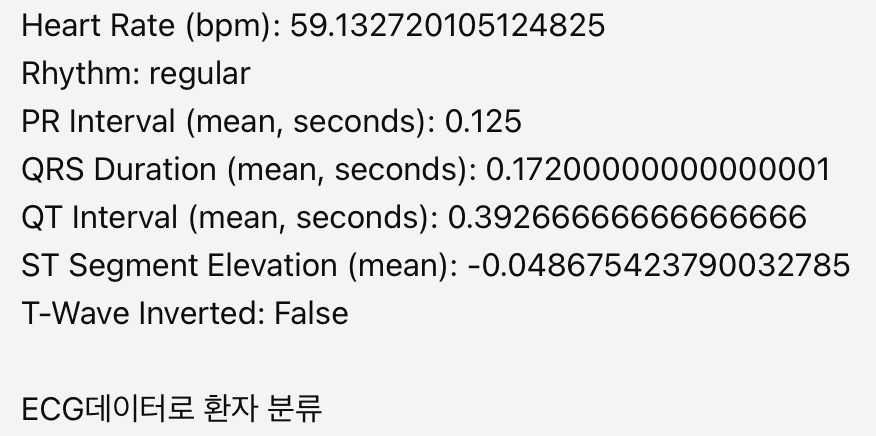

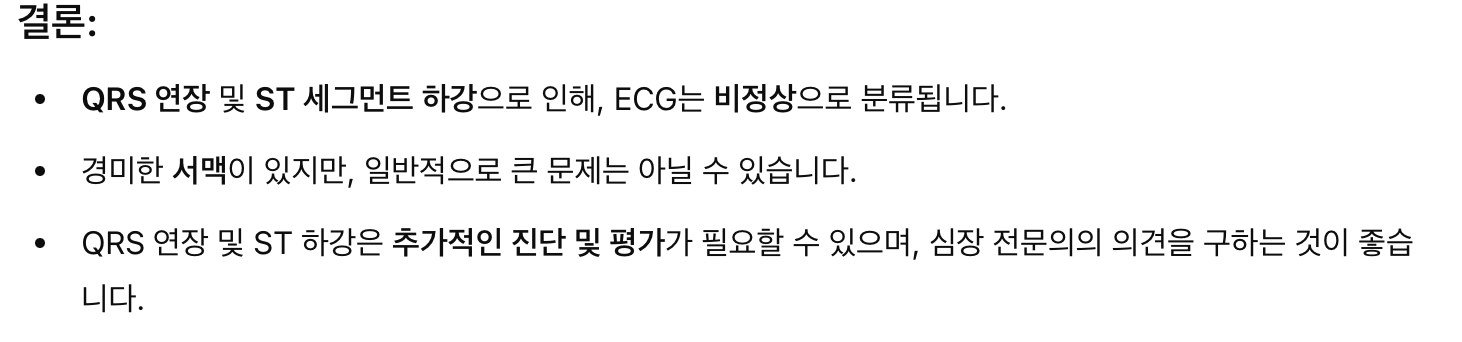

# 정답: CD